In [14]:
import torch

print("PyTorch version:", torch.__version__)

print("Is CUDA available?:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)

PyTorch version: 2.5.1
Is CUDA available?: True
GPU Name: NVIDIA GeForce RTX 4070
CUDA version: 12.1


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import os
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
# Set dataset paths based on extracted ZIP folder
base_path = 'RAFDB'  # Adjusted base path
train_path = os.path.join(base_path, 'train')  # Training images
validation_path = os.path.join(base_path, 'test')  # Test 

# Dynamically count labels (avoid manual mismatch)
LABELS = sorted(os.listdir(train_path))  # Get class names from folder structure
nb_classes = len(LABELS)  # Automatically set the number of classes

# Display detected classes
print(f"Classes detected: {LABELS}")
print(f"Number of classes: {nb_classes}")

Classes detected: ['1', '2', '3', '4', '5', '6', '7']
Number of classes: 7


In [17]:
# Define data preprocessing
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [18]:
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=validation_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [19]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 3, 48, 48) 
            out = self.conv_layers(dummy)
            flatten_dim = out.view(1, -1).shape[1]

        self.fc_layers = nn.Sequential(
            nn.Linear(flatten_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNN(nb_classes).to(device)


In [21]:
# Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


In [22]:
# Training model
best_val_acc = 0.0
save_path = "best_model.pth"
num_epochs = 50
patience = 3  # Early Stop Patience Value
no_improve_epochs = 0
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    cnn_model.train()
    running_loss, correct, total = 0.0, 0, 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        progress_bar.set_postfix({"loss": f"{running_loss / len(train_loader):.4f}", "accuracy": f"{correct / total:.4f}"})
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    cnn_model.eval()
    correct, total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(cnn_model.state_dict(), save_path)
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping triggered.")
            break

# Load the best model and print the accuracy
cnn_model.load_state_dict(torch.load(save_path))
print(f"Loaded best model with accuracy: {best_val_acc:.2f}%")


Epoch 1/50: 100%|███████████████████████████████████| 384/384 [00:12<00:00, 31.38batch/s, loss=1.5139, accuracy=0.4708]


Epoch 1/50, Train Loss: 1.5139, Val Loss: 1.1732, Train Acc: 47.08%, Val Acc: 60.10%


Epoch 2/50: 100%|███████████████████████████████████| 384/384 [00:11<00:00, 32.85batch/s, loss=1.1732, accuracy=0.5962]


Epoch 2/50, Train Loss: 1.1732, Val Loss: 0.9802, Train Acc: 59.62%, Val Acc: 65.16%


Epoch 3/50: 100%|███████████████████████████████████| 384/384 [00:11<00:00, 33.04batch/s, loss=1.0244, accuracy=0.6458]


Epoch 3/50, Train Loss: 1.0244, Val Loss: 0.9213, Train Acc: 64.58%, Val Acc: 67.70%


Epoch 4/50: 100%|███████████████████████████████████| 384/384 [00:11<00:00, 33.65batch/s, loss=0.9457, accuracy=0.6691]


Epoch 4/50, Train Loss: 0.9457, Val Loss: 0.8559, Train Acc: 66.91%, Val Acc: 69.72%


Epoch 5/50: 100%|███████████████████████████████████| 384/384 [00:11<00:00, 33.39batch/s, loss=0.8908, accuracy=0.6878]


Epoch 5/50, Train Loss: 0.8908, Val Loss: 0.7932, Train Acc: 68.78%, Val Acc: 72.29%


Epoch 6/50: 100%|███████████████████████████████████| 384/384 [00:11<00:00, 33.49batch/s, loss=0.8290, accuracy=0.7077]


Epoch 6/50, Train Loss: 0.8290, Val Loss: 0.8063, Train Acc: 70.77%, Val Acc: 70.57%


Epoch 7/50: 100%|███████████████████████████████████| 384/384 [00:11<00:00, 33.49batch/s, loss=0.8021, accuracy=0.7176]


Epoch 7/50, Train Loss: 0.8021, Val Loss: 0.7480, Train Acc: 71.76%, Val Acc: 73.17%


Epoch 8/50: 100%|███████████████████████████████████| 384/384 [00:11<00:00, 33.58batch/s, loss=0.7711, accuracy=0.7341]


Epoch 8/50, Train Loss: 0.7711, Val Loss: 0.7184, Train Acc: 73.41%, Val Acc: 74.93%


Epoch 9/50: 100%|███████████████████████████████████| 384/384 [00:11<00:00, 33.06batch/s, loss=0.7531, accuracy=0.7311]


Epoch 9/50, Train Loss: 0.7531, Val Loss: 0.7155, Train Acc: 73.11%, Val Acc: 74.90%


Epoch 10/50: 100%|██████████████████████████████████| 384/384 [00:11<00:00, 32.88batch/s, loss=0.7255, accuracy=0.7426]


Epoch 10/50, Train Loss: 0.7255, Val Loss: 0.7222, Train Acc: 74.26%, Val Acc: 74.58%


Epoch 11/50: 100%|██████████████████████████████████| 384/384 [00:11<00:00, 32.94batch/s, loss=0.7040, accuracy=0.7513]


Epoch 11/50, Train Loss: 0.7040, Val Loss: 0.7297, Train Acc: 75.13%, Val Acc: 74.51%
Early stopping triggered.
Loaded best model with accuracy: 74.93%


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9392\2661957803.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load(save_path))


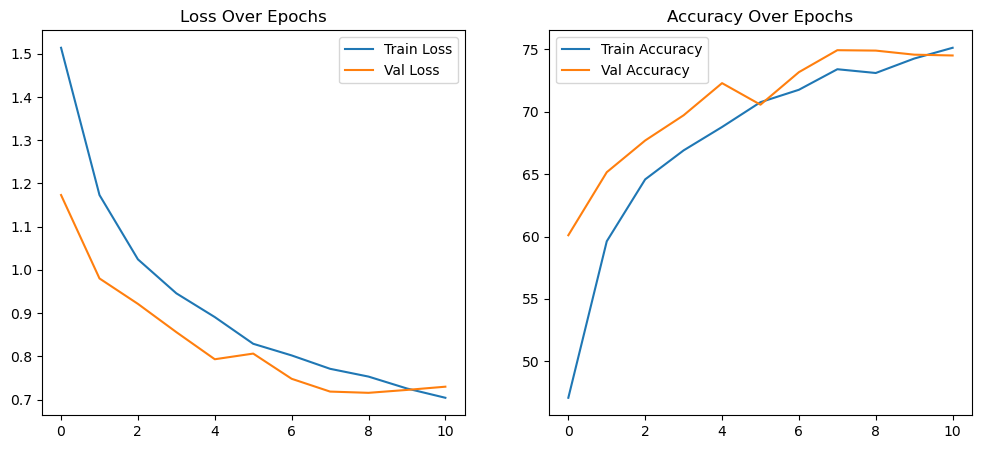

In [23]:
# Drawing training curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

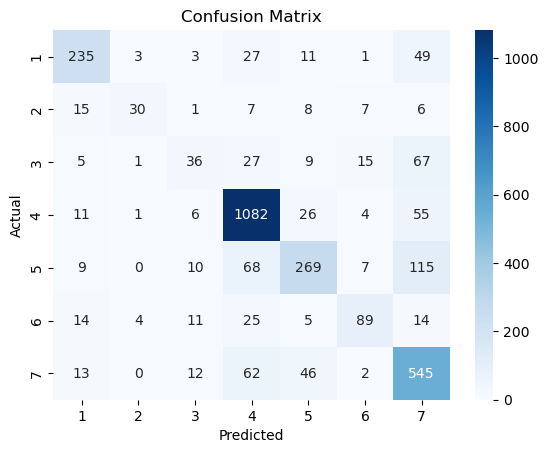

In [24]:
# Confusion Matrix
all_labels, all_preds = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Convert the index to category name
label_names = train_dataset.classes
all_labels = [label_names[label] for label in all_labels]
all_preds = [label_names[pred] for pred in all_preds]

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=label_names)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



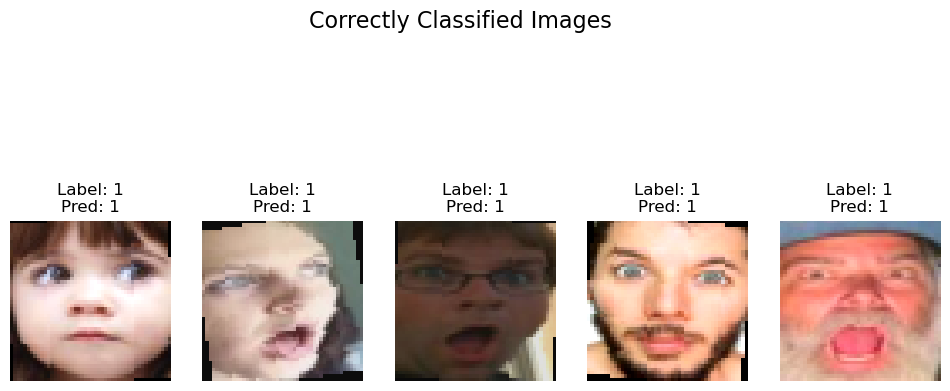

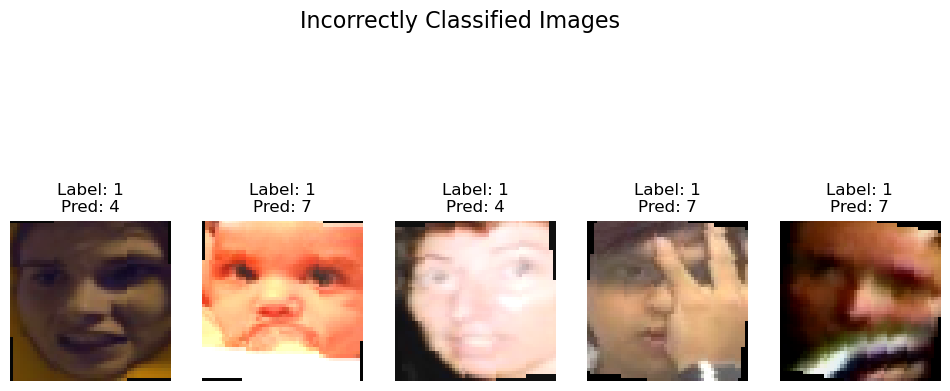

In [25]:
correct_images, incorrect_images = [], []
cnn_model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        
        for img, label, pred in zip(images, labels, predicted):
            img_np = img.cpu().numpy().transpose((1, 2, 0))
            img_np = img_np * 0.5 + 0.5  # Inverse Normalization
            if label == pred and len(correct_images) < 5:
                correct_images.append((img_np, label.item(), pred.item()))
            elif label != pred and len(incorrect_images) < 5:
                incorrect_images.append((img_np, label.item(), pred.item()))

def show_images(images, title):
    plt.figure(figsize=(12, 6))
    for i, (img, label, pred) in enumerate(images):
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Label: {train_dataset.classes[label]}\nPred: {train_dataset.classes[pred]}")
    plt.suptitle(title, fontsize=16)
    plt.show()

if correct_images:
    show_images(correct_images, "Correctly Classified Images")
if incorrect_images:
    show_images(incorrect_images, "Incorrectly Classified Images")
